# Headlines

The first thing we'll do is read in the headlines we'll be examining. We'll be cleaning them up by removing trailing whitespace and converting from Unicode to ASCII for ease-of-processing later.

In [1]:
import re
import geonamescache
from unidecode import unidecode
import pandas as pd
import numpy as np

gc = geonamescache.GeonamesCache()
_accented_names = (city['name'] for city in gc.get_cities().values() if city['name'] != unidecode(city['name']))
unicode_names = {unidecode(name): name for name in _accented_names}

In [2]:
with open("data/headlines.txt") as headline_file:
    # Remove any unnecessary leading whitespace for consistency
    headlines = [ unidecode(line.strip()) for line in headline_file ]

# Regular Expressions

We have to determine the country and/or city in any given headline (if there is one!). We'll do that by creating many Regular Expressions based on each city/country that we'll use to parse each headline later.

In [3]:
countries = gc.get_countries_by_names().keys()
# Pad the country regex string with word boundary meta-characters to avoid false matches
country_regex_strgen = (r"\b{}\b".format(unidecode(country)) for country in countries)
country_regexes = [re.compile(country, re.ASCII) for country in country_regex_strgen]

cities = gc.get_cities()
# Same as the country regex strings, add word boundary meta-characters
city_regex_strgen = (r"\b{}\b".format(unidecode(cities[id]['name'])) for id in cities.keys())
city_regexes = [re.compile(city, re.ASCII) for city in city_regex_strgen]

## Regex: Longest Match

If location names are similar, we may get multiple matches. We want to filter through these to ensure we're finding the correct location. We'll do this by only choosing the longest matching string.

e.g. If we have the headline "Zika confirmed in Miami Beach", the regexes for "Miami" and "Miami Beach" will both match, but since "Miami Beach" is longer, we'll associate the headline with Miami Beach.

In [4]:
def find_longest_match(regex_list, line):
    longest_match = ""
    for regex in regex_list:
        result = regex.search(line)
        if result:
            if len(result.group(0)) > len(longest_match):
                longest_match = result.group(0)
    # Return None only if we have an empty string
    return longest_match if longest_match else None

In [5]:
data = dict(headline=[], country=[], city=[])
for headline in headlines:
    data['headline'].append(headline)
    data['country'].append(find_longest_match(country_regexes, headline))
    data['city'].append(find_longest_match(city_regexes, headline))

df = pd.DataFrame.from_dict(data)

We'll add Latitude, Longitude, and Country Code columns for use later.

In [6]:
df['latitude'] = 0.0
df['longitude'] = 0.0
df['countrycode'] = ''

# Augmenting Location Data

Now that we've read the initial Headline/Country/City data into the DataFrame, we'll augment it by adding a Latitude, Longitude, and country code for each location we can. This will make it easier to group the data by location later.

Also, since the "Country" column proved fairly empty, we'll remove it from our table, along with any row that we didn't get a location for. Now, we should be left with rows that have workable location data.

In [7]:
all_cities = df[df.city.notna()]['city'].unique()
for city in all_cities:
    # Get the Unicode city name if it exists, otherwise keep the ASCII name
    uni_city = unicode_names.get(city, city)
    # Adapted from "Data Science Bookcamp - Location Tracking Using GeoNamesCache"
    best_match = max(gc.get_cities_by_name(uni_city), key=lambda x: list(x.values())[0]['population'])
    best_match = list(best_match.values())[0]  # To allow for accessing the city dictionary
    
    # Augment the DataFrame with the new lat/long/country code we found
    df.loc[df.city==city, ['latitude', 'longitude', 'countrycode']] = \
            float(best_match['latitude']), float(best_match['longitude']), best_match['countrycode']

In [8]:
df.drop(columns=['country'], inplace=True)
df.dropna(inplace=True)

# Visualizing before Clustering

First, we'll try just looking at our data and make sure our data makes sense. From here, we can try "eyeballing" some values for k-mean clustering and DBSCAN.

In [9]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

map_plotter = Basemap()

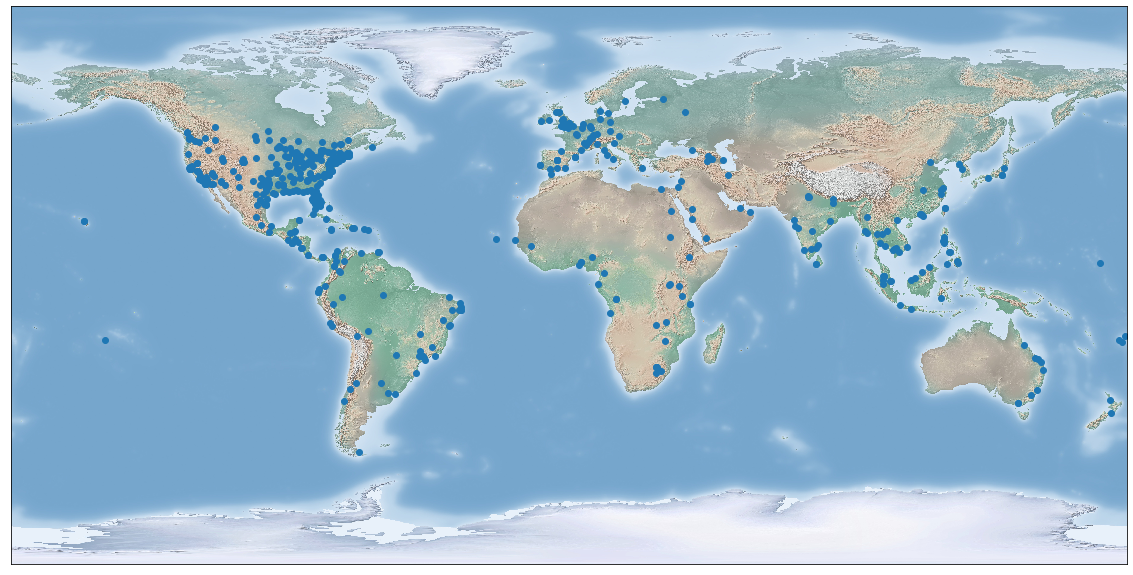

In [10]:
lat_long_pairs = df[['latitude', 'longitude']].to_numpy()
latitudes, longitudes = lat_long_pairs.T
fig = plt.figure(figsize=(20, 12))
map_plotter.scatter(longitudes, latitudes, latlon=True)
map_plotter.shadedrelief()
plt.show()

## Visualizing: K-Mean Elbow Plotting

Since there are many reasonably-sized centers of points, we'll try elbow plotting to figure out a reasonable k-value. 

k=6 may be a good first guess, since there are 6 continents with points.

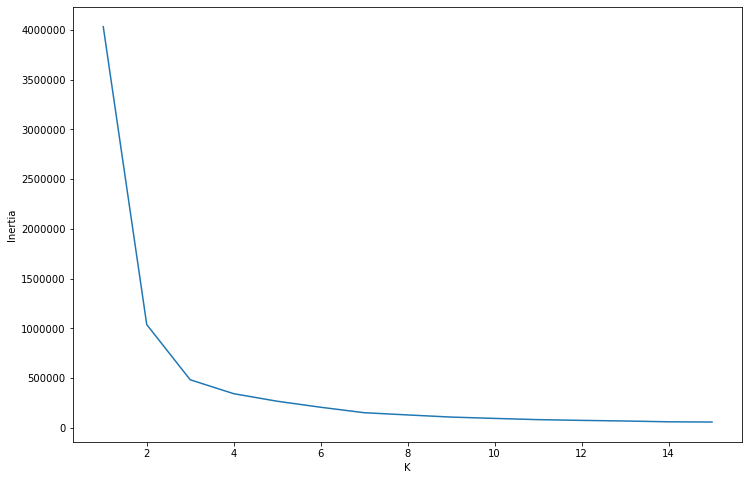

1: 4033338.336
2: 1038622.470
3: 483871.819
4: 343932.201
5: 268137.069
6: 207610.482
7: 152755.610
8: 130327.299
9: 108805.564
10: 95341.950
11: 83074.197
12: 75610.686
13: 69374.482
14: 61319.580
15: 58975.513


In [11]:
k_values = range(1, 16)
inertia_values = [KMeans(n_clusters=i).fit(lat_long_pairs).inertia_ for i in k_values]

plt.figure(figsize=(12, 8))
plt.plot(k_values, inertia_values)
plt.xlabel("K")
plt.ylabel("Inertia")
plt.show()
for i, v in enumerate(inertia_values, start=1):
    print(f"{i}: {v:.3f}")

# Clustering: K-Means

Since 5 is the last "elbow" in the curve, it looks like a guess of 6 wasn't a bad start. We'll still try 6 as our k-value, and create a DataFrame with this number of clusters in mind. However, this may not prove optimal since we're interested in dense outbreak regions rather than outbreak regions with a certain center.

In [25]:
# From https://stackoverflow.com/questions/14720331/how-to-generate-random-colors-in-matplotlib
# Used for colormapping more than 10 colors, to prevent
# different clusters in close proximity from causing confusion when drawn
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

In [32]:
NUM_CLUSTERS = 13
clusters = KMeans(n_clusters=NUM_CLUSTERS).fit_predict(lat_long_pairs)
df_kmean = df.copy()
df_kmean['cluster'] = clusters

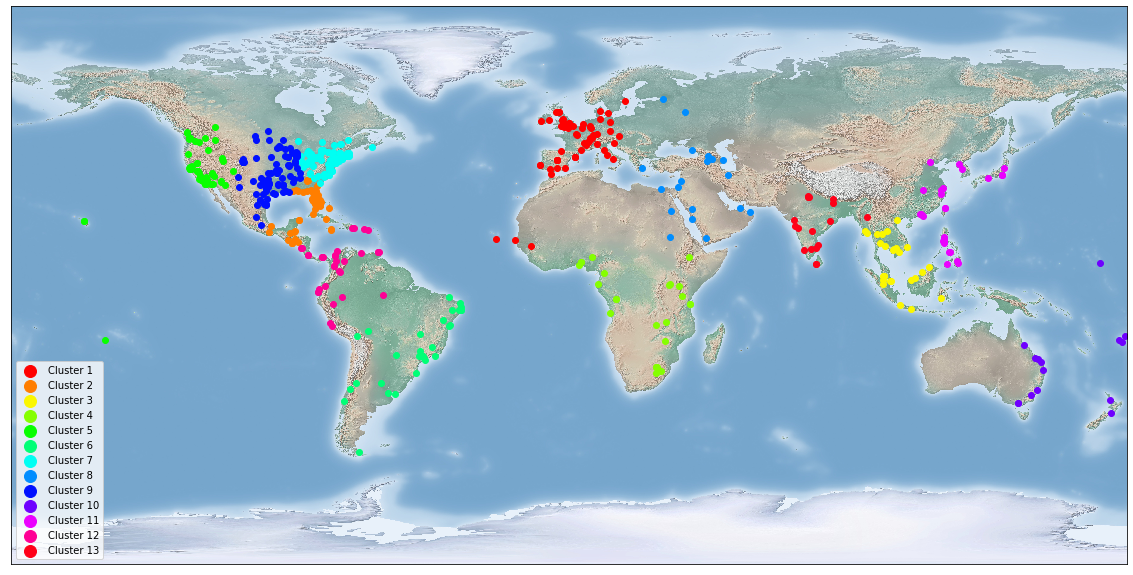

In [33]:
plt.figure(figsize=(20, 12))
cmap = get_cmap(len(df_kmean.groupby('cluster')))
for cluster_id, cluster in df_kmean.groupby('cluster'):
    if cluster_id == -1: continue
    map_plotter.scatter(cluster.longitude, cluster.latitude, latlon=True, color=cmap(cluster_id))
    
map_plotter.shadedrelief()
#map_plotter.drawcoastlines()
#map_plotter.drawcountries()
plt.legend( [f"Cluster {i}" for i in range(1, NUM_CLUSTERS+1)], \
               loc="lower left", markerscale=2, fontsize="medium" )
plt.show()
#plt.savefig("kmeans.png", dpi=300, orientation="landscape")

So while at first glance this map looks fine (k=6), there are some obvious problems (e.g. Pacific Asia and Australia are one cluster) that indicate we have to change some parameters. In this case, we'll add more than 6 clusters.

After further experimentation, k=13 seems to be a reasonable number of clusters.

# Clustering: DBSCAN

Since we're trying to locate clusters of regions based on the proximity of other cities in distress, it may be a good idea to do density-based clustering, since certain regions may be more dense than others and require a limiting of resources, or require more resources to cover a larger area, etc.

In [14]:
# Based on the Haversine formula, found here: https://www.movable-type.co.uk/scripts/latlong.html
# REMOVE NUMBA BELOW THIS FOR RELEASE
from numba import jit
@jit(nopython=True) # REMOVE NUMBA TO THE LEFT AND ABOVE THIS FOR RELEASE
def great_circle(point_1, point_2):
    RADIUS = np.int64(6371)  # Kilometers, Earth's mean radius
    lat_1 = np.radians(point_1[0])
    lat_2 = np.radians(point_2[0])
    d_lat = lat_2 - lat_1
    d_long = np.radians(point_2[1] - point_1[1])
    a = np.sin(d_lat/2) * np.sin(d_lat/2) + np.cos(lat_1) * np.cos(lat_2) * np.sin(d_long/2) * np.sin(d_long/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return RADIUS * c

In [18]:
MAX_KM = 500  # 403km is about 250 miles
MIN_LOC = 5
clusters = DBSCAN(eps=MAX_KM, min_samples=MIN_LOC, metric=great_circle).fit_predict(lat_long_pairs)
df_dbscan = df.copy()
df_dbscan['cluster'] = clusters

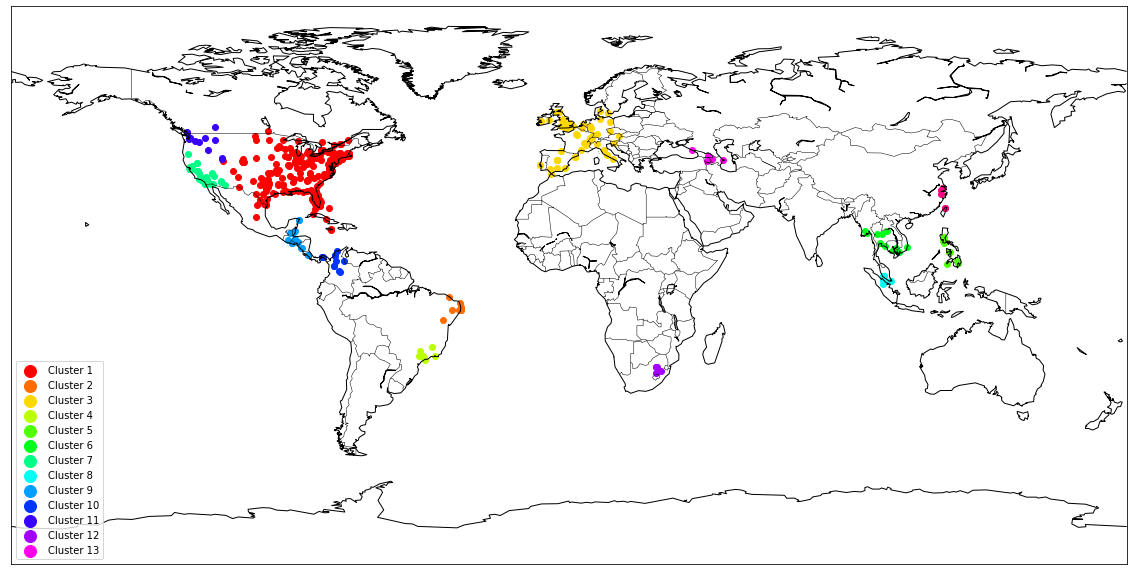

In [23]:
NUM_CLUSTERS = df_dbscan.cluster.max()
plt.figure(figsize=(20, 12))
cmap = get_cmap(len(df_dbscan.groupby('cluster')))
for cluster_id, cluster in df_dbscan.groupby('cluster'):
    if cluster_id == -1: continue
    map_plotter.scatter(cluster.longitude, cluster.latitude, latlon=True, color=cmap(cluster_id))
    
#map_plotter.shadedrelief()
map_plotter.drawcoastlines()
map_plotter.drawcountries()
plt.legend( [f"Cluster {i}" for i in range(1, NUM_CLUSTERS+1)], \
               loc="lower left", markerscale=2, fontsize="medium" )
#plt.show()
plt.savefig("dbscan.png", dpi=300, orientation="landscape")

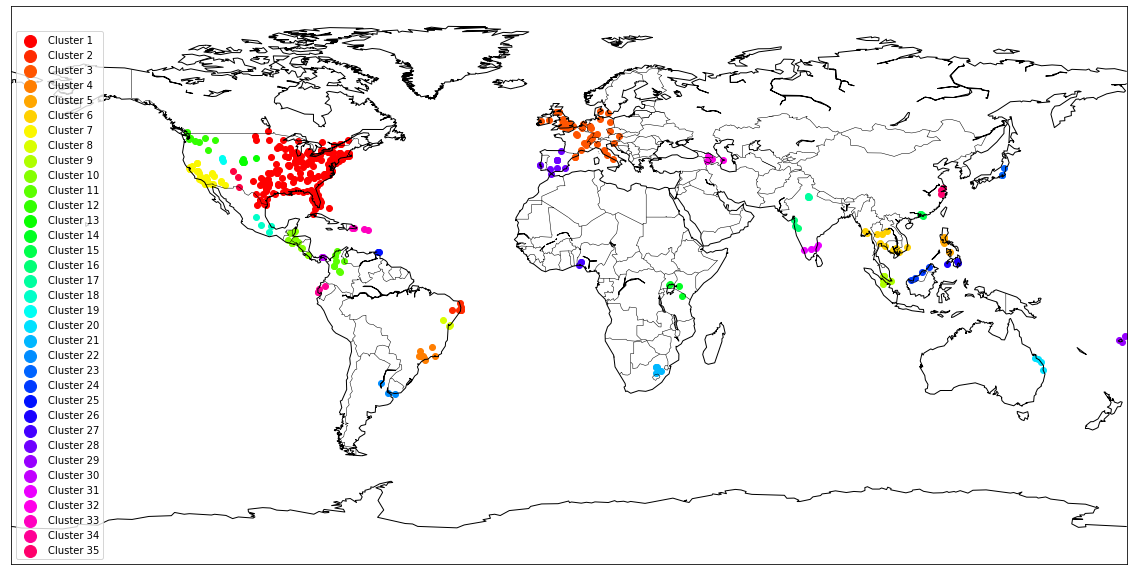

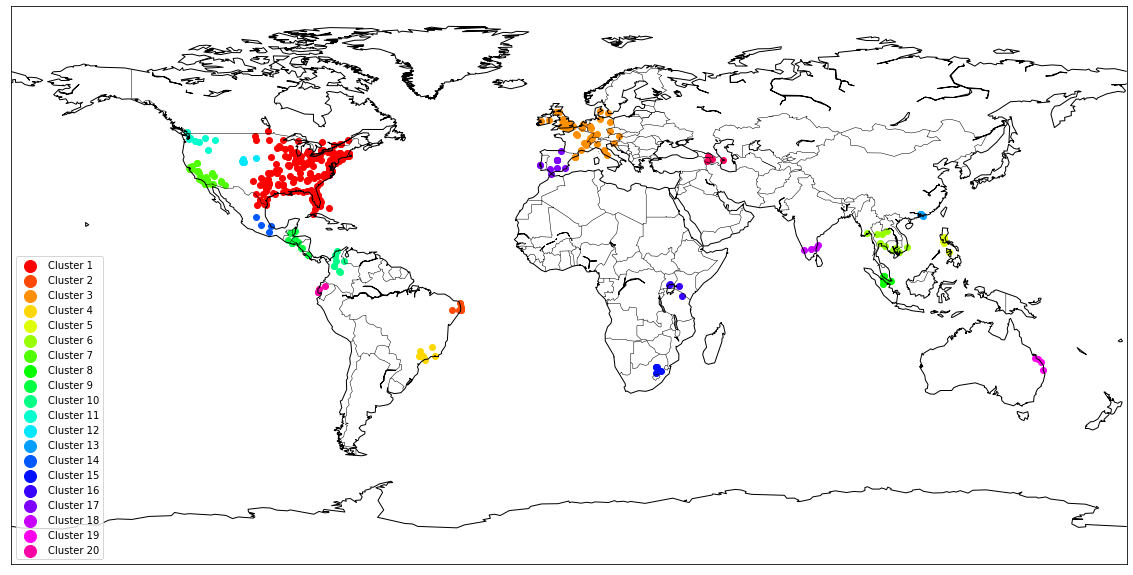

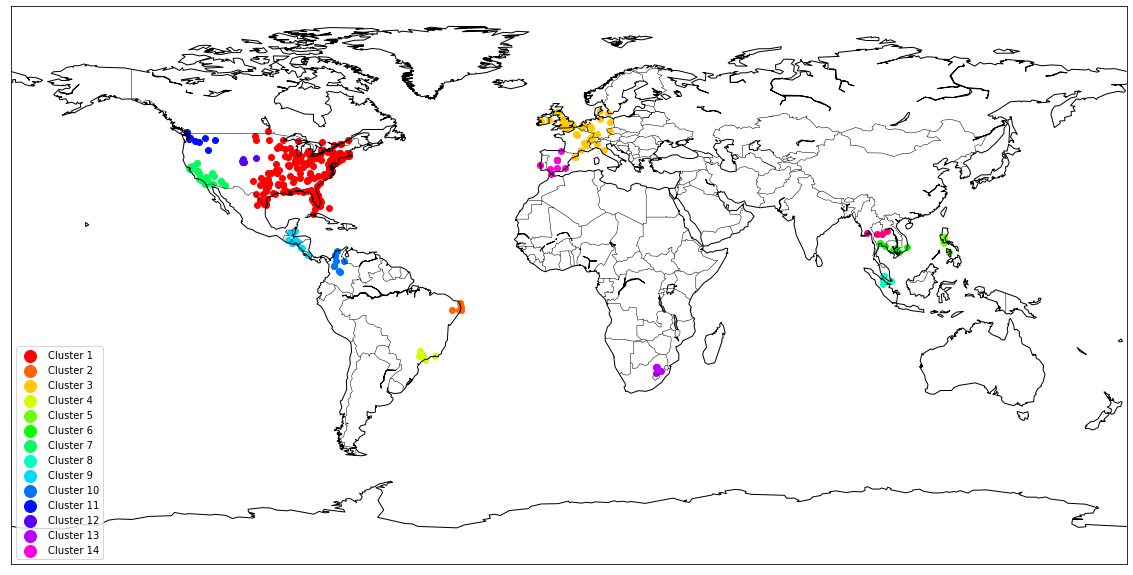

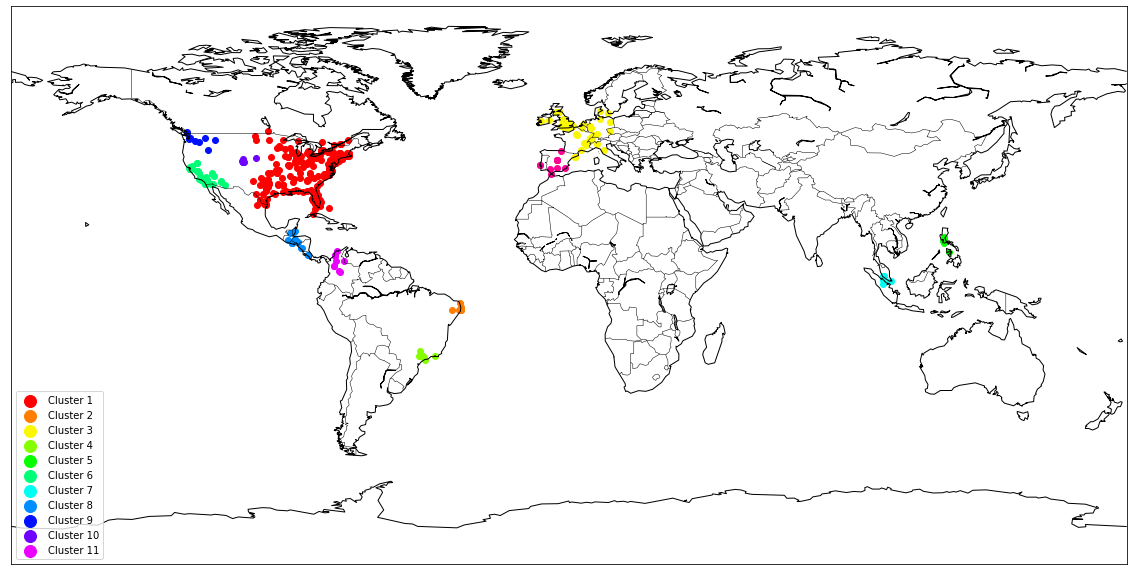

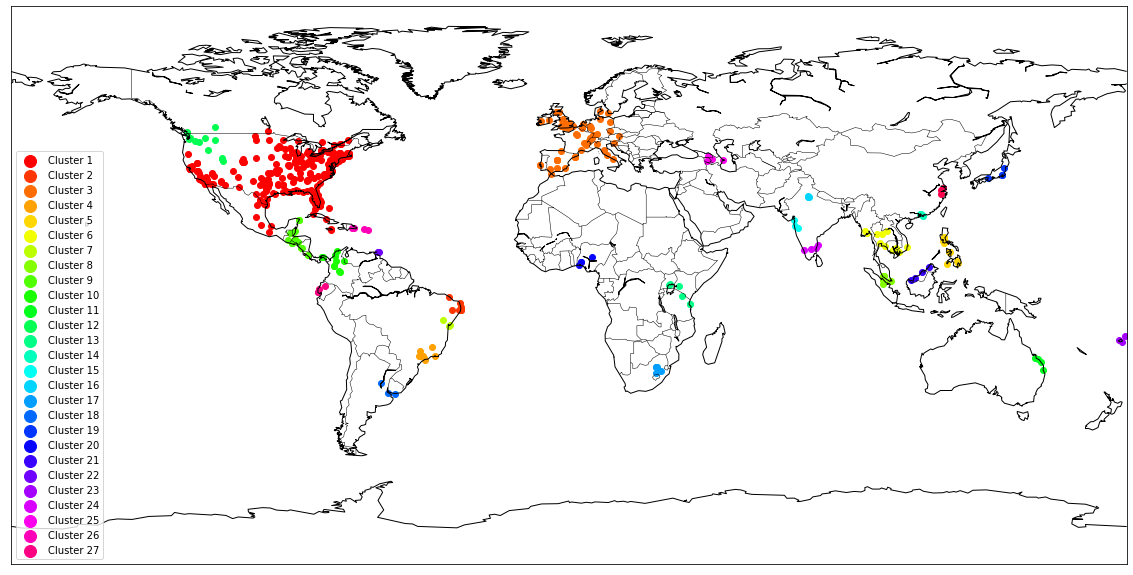

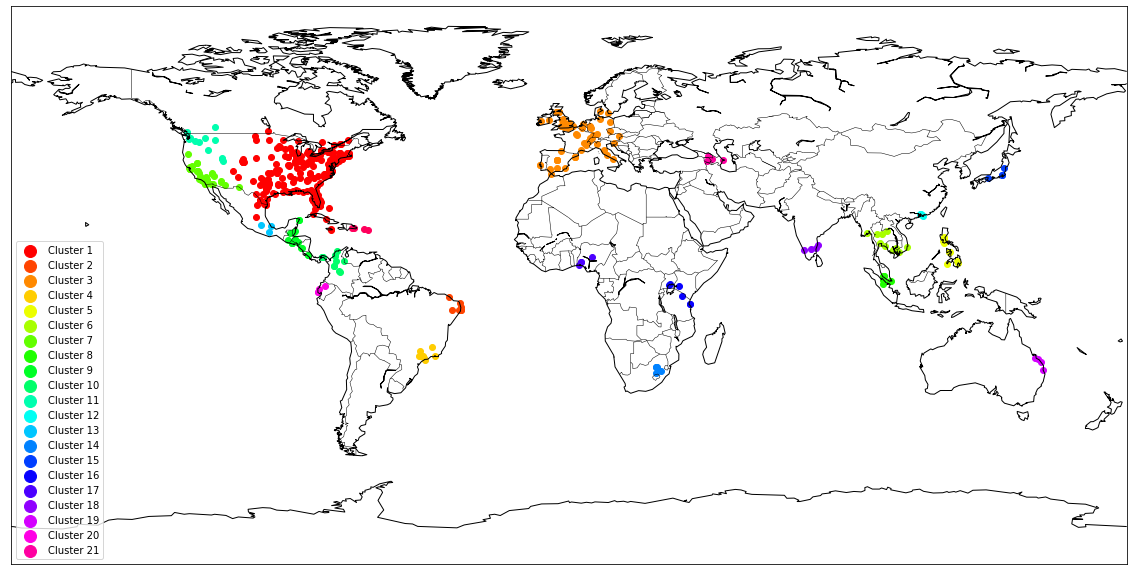

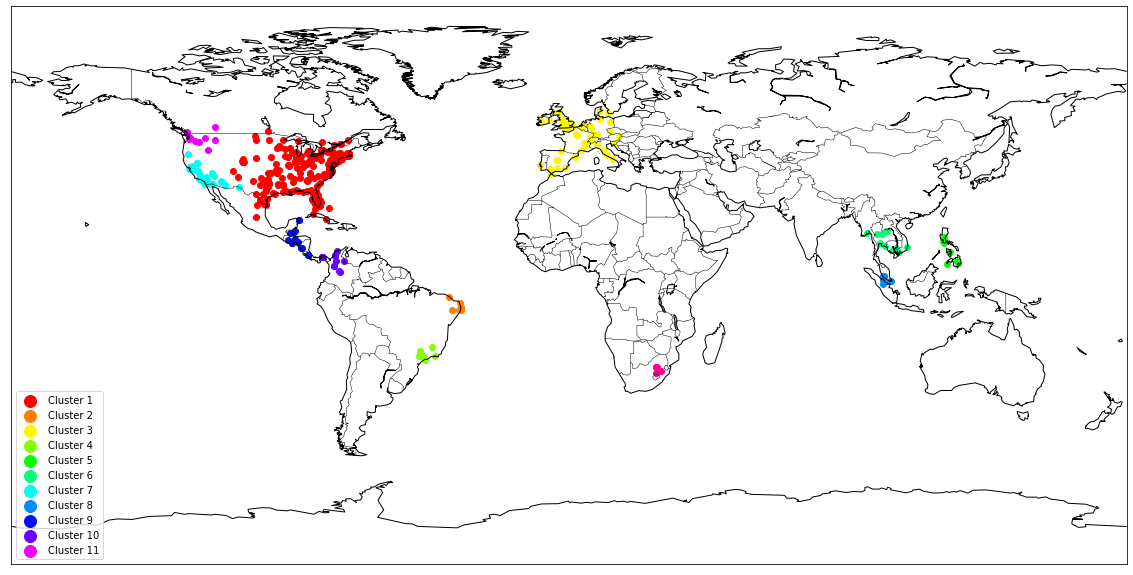

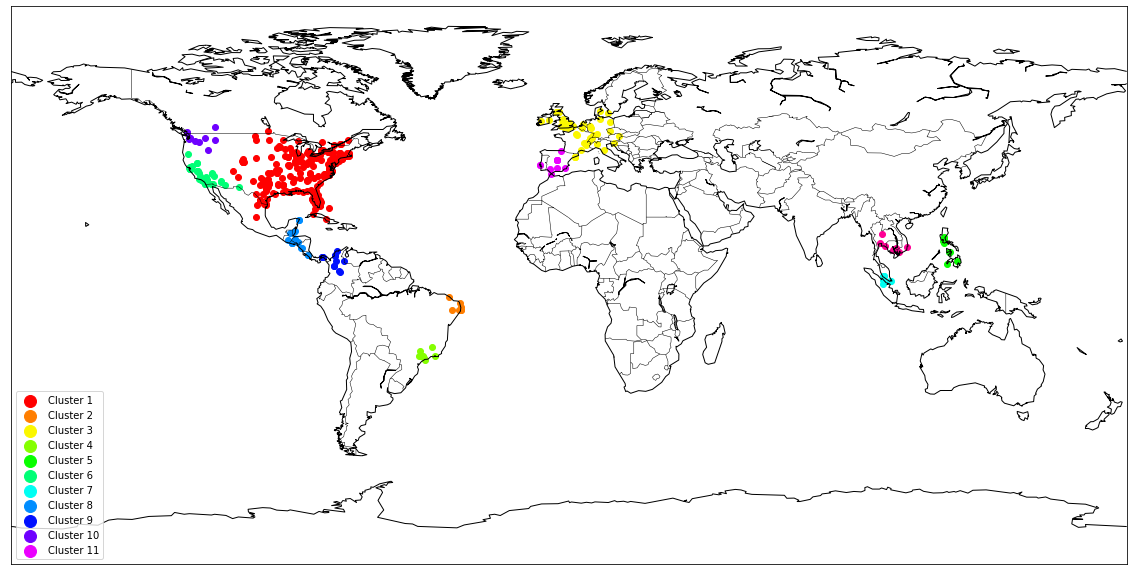

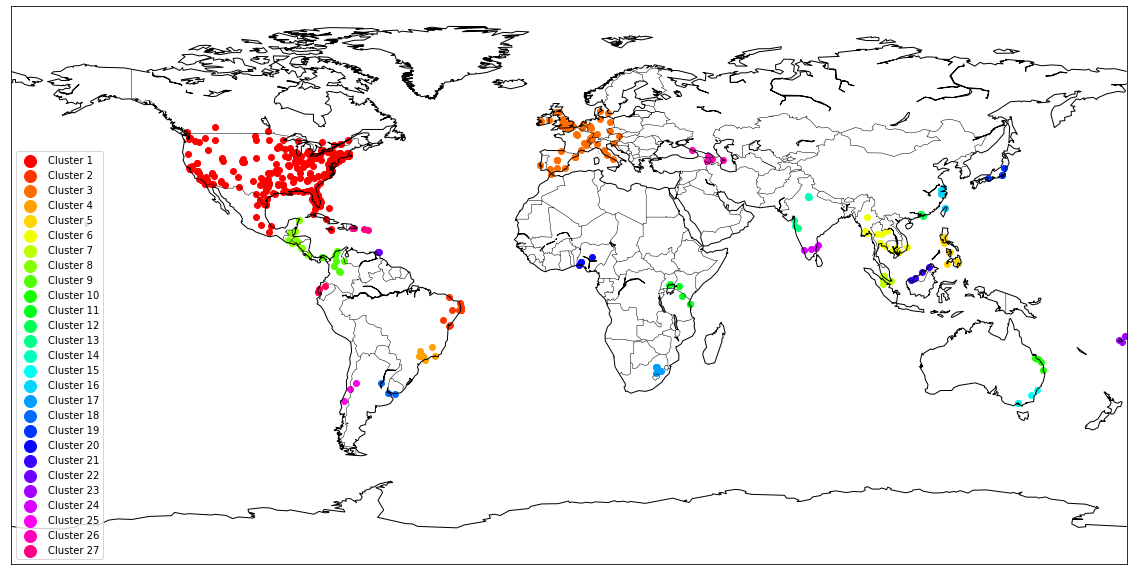

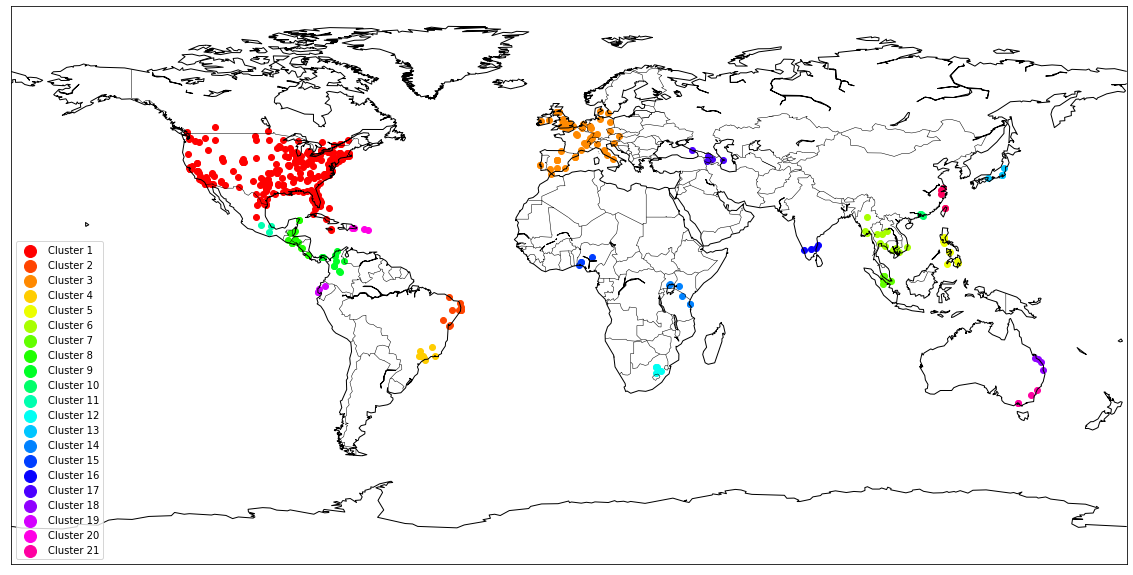

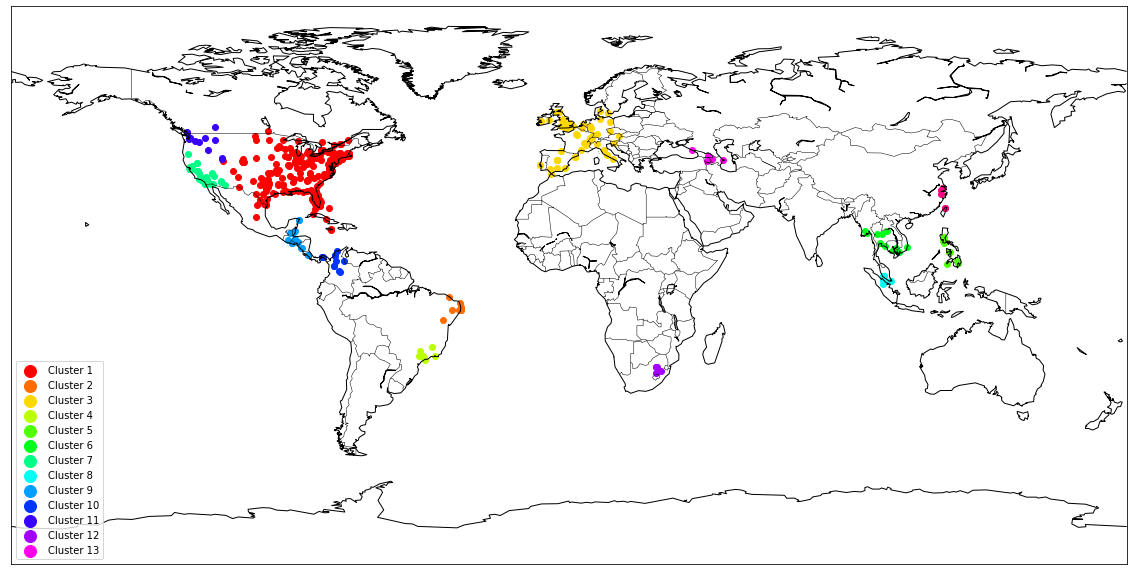

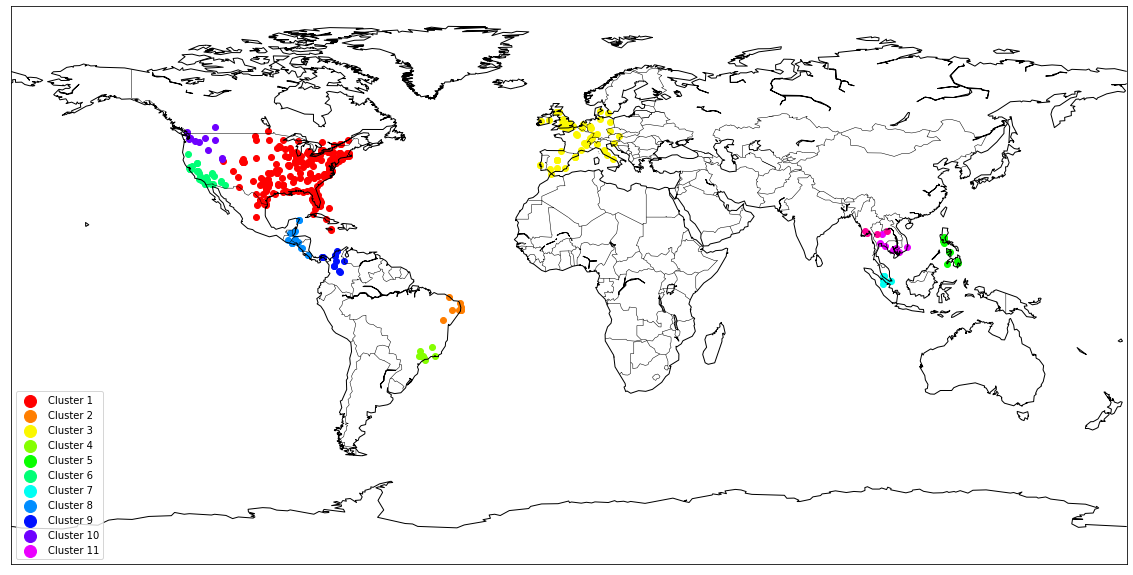

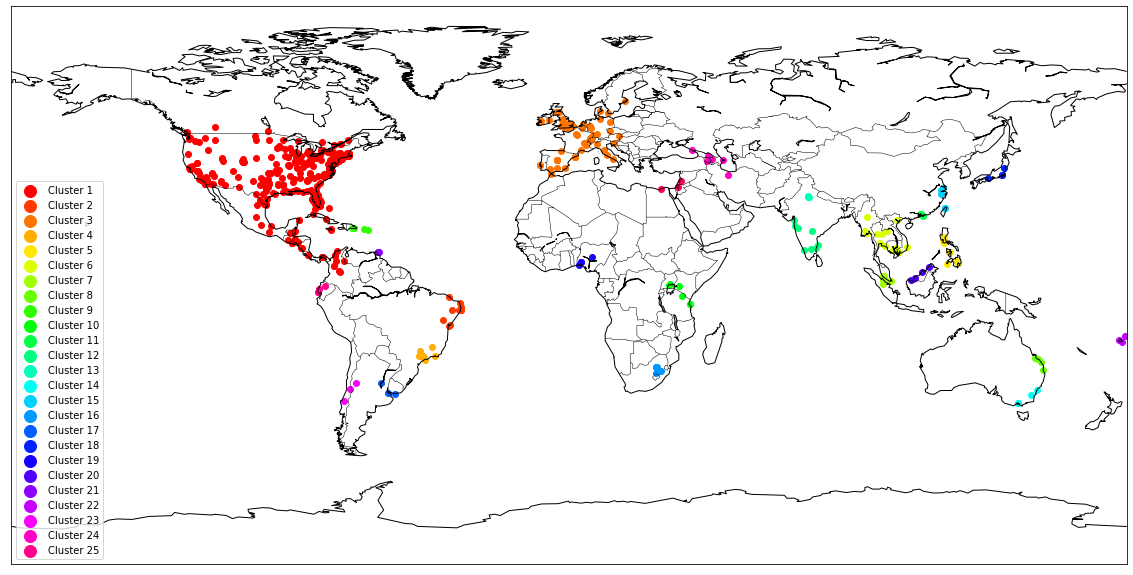

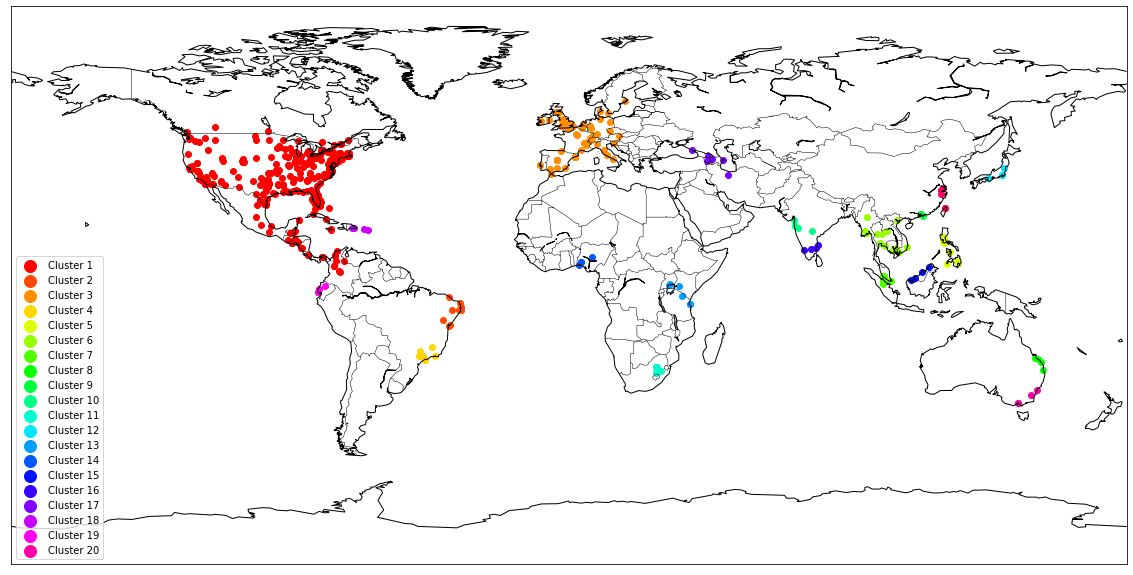

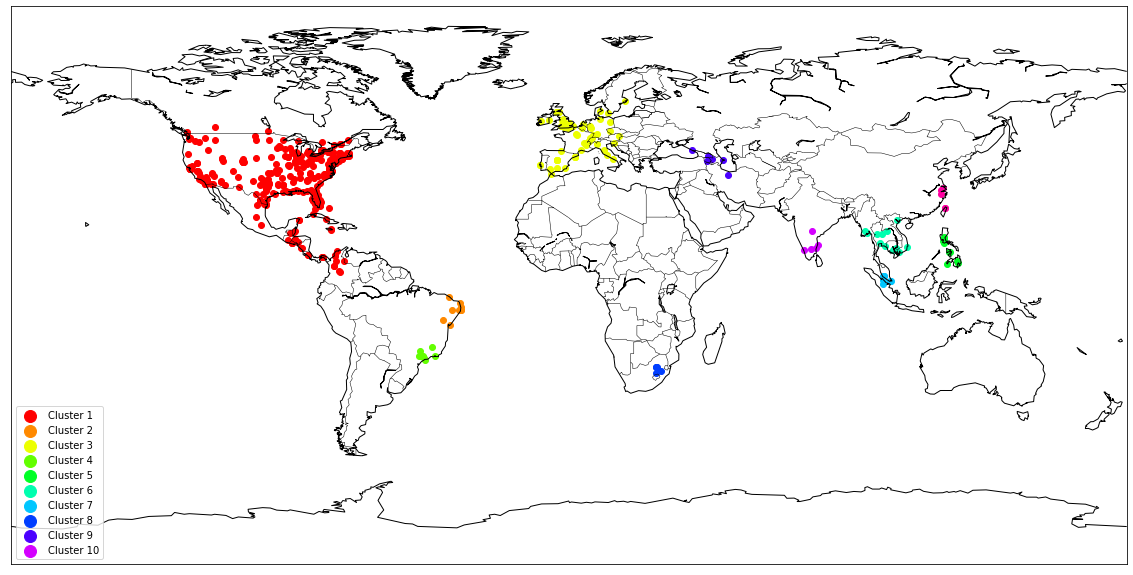

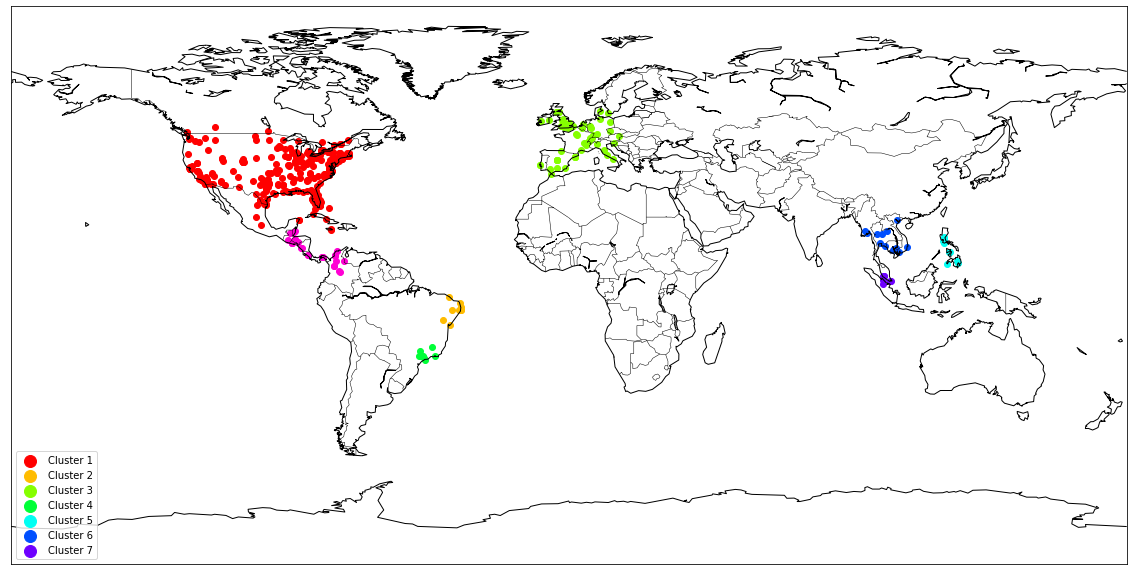

In [24]:
# Brute force experimentation
from itertools import product
km_vars = [400, 450, 500, 550]
city_vars = [3, 4, 5, 6]
for _MAX_KM, MIN_LOCATION in product(km_vars, city_vars):
    clusters = DBSCAN(eps=_MAX_KM, min_samples=MIN_LOCATION, metric=great_circle).fit_predict(lat_long_pairs)
    df_dbscan = df.copy()
    df_dbscan['cluster'] = clusters
    NUM_CLUSTERS = df_dbscan.cluster.max()
    plt.figure(figsize=(20, 12))
    cmap = get_cmap(len(df_dbscan.groupby('cluster')))
    for cluster_id, cluster in df_dbscan.groupby('cluster'):
        if cluster_id == -1: continue
        map_plotter.scatter(cluster.longitude, cluster.latitude, latlon=True, color=cmap(cluster_id))
    
    #map_plotter.shadedrelief()
    map_plotter.drawcoastlines()
    map_plotter.drawcountries()
    plt.legend( [f"Cluster {i}" for i in range(1, NUM_CLUSTERS+1)], \
               loc="lower left", markerscale=2, fontsize="medium" )
    #plt.show()
    plt.savefig(f"dbscan_km{_MAX_KM}_city{MIN_LOCATION}.png", dpi=300, orientation="landscape")